In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import random
import cv2
import numpy as np
!pip install pyefd
import pyefd
from google.colab.patches import cv2_imshow
!pip install cairocffi
import cairocffi as cairo
import struct
from struct import unpack

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=b1ba72a2b8ea08505e4d599103305662acb1805e4bc4a020ac78165fb7a1137d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


Section 1: Fourier Descriptors through linear classifier

In [3]:
# Env vars
torch.use_deterministic_algorithms(False)

# Const vars
LOAD_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001 wide-deep.pt'
RAND_SEED = 0
DEVICE = "cpu"

IMG_SIDE = 28
NUM_CLASSES = 343
EPOCHS = 10
BATCH_SIZE = 512
LOSS_FN = nn.CrossEntropyLoss()

In [4]:
def get_step(deltaX, deltaY):
  angle = np.arctan2(deltaY, deltaX)
  pi_over_8 = np.pi / 8
  if -pi_over_8 <= angle < pi_over_8:
    return (1, 0)
  elif pi_over_8 <= angle < 3 * pi_over_8:
    return (1, 1)
  elif 3 * pi_over_8 <= angle < 5 * pi_over_8:
    return (0, 1)
  elif 5 * pi_over_8 <= angle < 7 * pi_over_8:
    return (-1, 1)
  elif angle >= 7 * pi_over_8 or angle < -7 * pi_over_8:
    return (-1, 0)
  elif -7 * pi_over_8 <= angle < -5 * pi_over_8:
    return (-1, -1)
  elif -5 * pi_over_8 <= angle < -3 * pi_over_8:
    return (0, -1)
  else:
    return (1, -1)

def complete_contour(vector_img):
  complete_contour = []
  partial_contour = [point for stroke in vector_img for point in zip(*stroke)]
  if len(partial_contour) > 0:
    partial_contour.append(partial_contour[0])
    for i in range(len(partial_contour) - 1):
      x0, y0 = partial_contour[i]
      x1, y1 = partial_contour[i+1]
      if (x0, y0) == (x1, y1):
        continue
      complete_contour.append([x0, y0])
      deltaX = x1 - x0
      deltaY = y1 - y0
      while(max(abs(deltaX), abs(deltaY)) > 1):
        x_offset, y_offset = get_step(deltaX, deltaY)
        x0 += x_offset
        y0 += y_offset
        complete_contour.append([x0, y0])
        deltaX = x1 - x0
        deltaY = y1 - y0
  return np.asarray(complete_contour)

means = np.asarray([[1.00000000e+00,  1.70292625e-19,  1.37157261e-19, -2.97352773e-02],
 [ 3.93857845e-02,  1.14573042e-02,  1.11273905e-02, -1.27501456e-02],
 [ 1.26057258e-02,  1.27047894e-02,  2.20446418e-03, -5.17296120e-03],
 [ 4.60867346e-03,  2.54431263e-04, -2.24875991e-03, -2.43568670e-03],
 [-1.29011658e-03,  7.29537187e-04,  3.29306713e-04, -6.94848183e-05],
 [-2.20461684e-03, -4.26032423e-04,  3.70747798e-04,  6.67042619e-04],
 [ 1.06105248e-03,  5.59965312e-04, -2.48033261e-05, -3.27838867e-04],
 [ 6.92991267e-04,  7.77918380e-05,  1.26802111e-04, -4.82832044e-04],
 [ 2.05231401e-04, -1.29655496e-04, -1.44908870e-04, -2.86502180e-04],
 [-1.48524853e-04, -2.01465364e-04,  2.28534063e-04,  3.38029409e-04]])

stdevs = np.asarray([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.94827207e-01],
 [6.15715499e-01, 6.31045641e-01, 5.56262445e-01, 5.77054655e-01],
 [4.44723755e-01, 4.34617210e-01, 4.14754373e-01, 4.09847350e-01],
 [3.13965726e-01, 3.06039399e-01, 2.93664393e-01, 2.88944168e-01],
 [2.20598291e-01, 2.20428499e-01, 2.08627310e-01, 2.08939754e-01],
 [1.67779200e-01, 1.70621159e-01, 1.61133731e-01, 1.60840793e-01],
 [1.35504574e-01, 1.33753600e-01, 1.28539543e-01, 1.29087092e-01],
 [1.08136940e-01, 1.08601151e-01, 1.04438585e-01, 1.03887367e-01],
 [9.21341521e-02, 9.22050837e-02, 8.90123677e-02, 8.74814102e-02],
 [7.74686779e-02, 7.69117614e-02, 7.27067303e-02, 7.27266299e-02]])
 
# transform functions - take sketch image, return torch tensor of descriptors
def fourier_transform(vector_img, is_test):
  contour = complete_contour(vector_img)

  # to-do
  # if is_test:
  
  coeffs = pyefd.elliptic_fourier_descriptors(contour, order=FOURIER_ORDER, normalize=True)
  coeffs = (coeffs - means) / stdevs
  return torch.from_numpy(coeffs.flatten()).float()

# helper method to find class based on imgset index
def find_class(idx, num_list):
  class_id = 0
  sum = num_list[class_id]
  while idx >= sum:
    class_id += 1
    sum += num_list[class_id]
  return class_id

# deterministic worker re-seeding
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# custom dataset for quickdraw
class QuickdrawDataset(Dataset):
  def __init__(self, imgs, nums, is_test):
    self.imgs = imgs
    self.nums = nums
    self.len = sum(nums)
    self.is_test = is_test

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    img = self.imgs[idx]
    x = fourier_transform(img, self.is_test)
    y = find_class(idx, self.nums)
    return x, y


class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(FOURIER_ORDER * 4, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 1024)
    self.head = nn.Linear(1024, NUM_CLASSES)
    self.relu = nn.ReLU()


  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.relu(x)
    return self.head(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # put the model in train mode
    total_loss = 0
    total_correct = 0
    # for each batch in the training set compute loss and update model parameters
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Compute prediction and loss
      out = model(x)
      loss = loss_fn(out, y)

      # Backpropagation to update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print current training metrics for user
      y, out, loss = y.to("cpu"), out.to("cpu"), loss.to("cpu")
      loss_val = loss.item()
      if batch % 100 == 0:
          current = (batch + 1) * BATCH_SIZE
          print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

      pred = out.argmax(dim=1, keepdim=True)
      correct = pred.eq(y.view_as(pred)).sum().item()
      total_correct += correct
      total_loss += loss_val
      # print(f"train loss: {loss_val:>7f}   train accuracy: {correct / BATCH_SIZE:>7f}   [batch: {batch + 1:>3d}/{(size // BATCH_SIZE) + 1:>3d}]")      
    print(f"\nepoch avg train loss: {total_loss / ((size // BATCH_SIZE) + 1):>7f}   epoch avg train accuracy: {total_correct / size:>7f}")
      
def eval_loop(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      total_correct += pred.eq(y.view_as(pred)).sum().item()

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")


In [5]:
# define methods for unpacking Quickdraw .bin files
def unpack_drawing(file_handle):
  file_handle.read(15)
  n_strokes, = unpack('H', file_handle.read(2))
  image = []
  for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      image.append((x, y))

  return image


def unpack_drawings(filename):
  imageset = []
  with open(filename, 'rb') as f:
      while True:
          try:
              imageset.append(unpack_drawing(f))
          except struct.error:
              break
  return imageset

train_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Train/'
test_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Test/'
train_imgs = []
test_imgs = []
train_nums = []
test_nums = []
list_of_classes = ["The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
                   "aircraft carrier", "airplane", "alarm clock", "ambulance", 
                   "angel", "ant", "anvil", "apple", "arm", "asparagus", "axe", 
                   "backpack", "banana", "bandage", "barn", "baseball bat", 
                   "baseball", "basket", "basketball", "bathtub", "beach", "bear", 
                   "beard", "bed", "bee", "belt", "bench", "bicycle", "binoculars", 
                   "bird", "birthday cake", "blackberry", "blueberry", "book", 
                   "boomerang", "bottlecap", "bowtie", "bracelet", "brain", 
                   "bread", "bridge", "broccoli", "broom", "bucket", "bulldozer", 
                   "bus", "bush", "butterfly", "cactus", "cake", "calculator", 
                   "calendar", "camel", "camera", "camouflage", "campfire", 
                   "candle", "cannon", "canoe", 'car', 'carrot', "castle", "cat", "ceiling fan", 
                   "cell phone", "cello", "chair", "chandelier", "church", 
                   "circle", "clarinet", "clock", "cloud", "coffee cup", 
                   "compass", "computer", "cookie", "cooler", "couch", "cow",
                   "crab", "crayon", "crocodile", "crown", "cruise ship", 
                   "cup", "diamond", "dishwasher", "diving board", "dog", 
                   "dolphin", "donut", "door", "dragon", "dresser", "drill", 
                   "drums", "duck", "dumbbell", "ear", "elbow", "elephant", 
                   "envelope", "eraser", "eye", "eyeglasses", "face", "fan",
                   "feather", "fence", "finger", "fire hydrant", "fireplace",
                   "firetruck", "fish", "flamingo", "flashlight", "flip flops", 
                   "floor lamp", "flower", "flying saucer", "foot", "fork", 
                   "frog", "frying pan", "garden hose", "garden", "giraffe", 
                   "goatee", "golf club", "grapes", "grass", "guitar", 
                   "hamburger", "hammer", "hand", "harp", "hat", "headphones", 
                   "hedgehog", "helicopter", "helmet", "hexagon", "hockey puck", 
                   "hockey stick", "horse", "hospital", "hot air balloon", 
                   "hot dog", "hot tub", "hourglass", "house plant", "house", 
                   "hurricane", "ice cream", "jacket", "jail", "kangaroo", 
                   "key", "keyboard", "knee", "knife", "ladder", "lantern", 
                   "laptop", "leaf", "leg", "light bulb", "lighter", "lighthouse",
                   "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
                   "mailbox", "map", "marker", "matches", "megaphone", "mermaid", 
                   "microphone", "microwave", "monkey", "moon", "mosquito", 
                   "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
                   "mushroom", "nail", "necklace", "nose", "ocean", "octagon", 
                   "octopus", "onion", "oven", "owl", "paint can", "paintbrush", 
                   "palm tree", "panda", "pants", "paper clip", "parachute", 
                   "parrot", "passport", "peanut", "pear", "peas", "pencil", 
                   "penguin", "piano", "pickup truck", "picture frame", "pig", 
                   "pillow", "pineapple", "pizza", "pliers", "police car", 
                   "pond", "pool", "popsicle", "postcard", "potato", 
                   "power outlet", "purse", "rabbit", "raccoon", "radio", 
                   "rain", 'rainbow', 'rake', 'remote control', 'rhinoceros', 
                   'rifle', 'river', 'roller coaster', 'rollerskates', 
                   'sailboat', 'sandwich', 'saw', 'saxophone', 'school bus', 
                   'scissors', 'scorpion', 'screwdriver', 'sea turtle', 
                   'see saw', 'shark', 'sheep', 'shoe', 'shorts', 'shovel', 
                   'sink', 'skateboard', 'skull', 'skyscraper', 'sleeping bag', 
                   'smiley face', 'snail', 'snake', 'snorkel', 'snowflake', 
                   'snowman', 'soccer ball', 'sock', 'speedboat', 'spider', 
                   'spoon', 'spreadsheet', 'square', 'squiggle', 'squirrel', 
                   'stairs', 'star', 'steak', 'stereo', 'stethoscope', 'stitches', 
                   'stop sign', 'stove', 'strawberry', 'streetlight', 
                   'string bean', 'submarine', 'suitcase', 'sun', 'swan', 
                   'sweater', 'swing set', 'sword', 'syringe', 't-shirt', 
                   'table', 'teapot', 'teddy-bear', 'telephone', 'television', 
                   'tennis racquet', 'tent', 'tiger', 'toaster', 'toe', 'toilet', 
                   'tooth', 'toothbrush', 'toothpaste', 'tornado', 'tractor', 
                   'traffic light', 'train', 'tree', 'triangle', 'trombone', 
                   'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 
                   'washing machine', 'watermelon', 'waterslide', 'whale', 
                   'wheel', 'windmill', 'wine bottle', 'wine glass', 'wristwatch', 
                   'yoga', 'zebra', 'zigzag']

In [6]:
# load dataset
for item in list_of_classes:
  train_folder = train_dir + item + '.bin'
  # test_folder = test_dir + item + '.bin'
  train_drawings = unpack_drawings(train_folder)
  train_imgs += train_drawings
  train_nums.append(len(train_drawings))
  # test_drawings = unpack_drawings(test_folder)
  # test_imgs += test_drawings
  # test_nums.append(len(test_drawings))

test accuracy: 0.220003


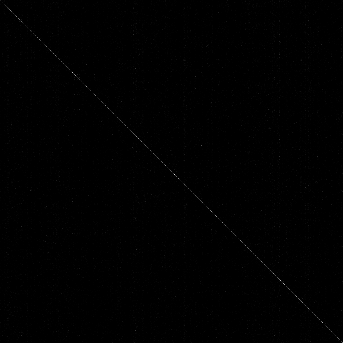

In [ ]:
FOURIER_ORDER = 20
DEVICE = "cpu"
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)
g = torch.Generator()
g.manual_seed(RAND_SEED)

def get_confusion_mat(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  conf_mat = np.zeros((343, 343))
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      y = y.view_as(pred)
      total_correct += pred.eq(y).sum().item()
      y, pred = y.numpy(), pred.numpy()
      indices = np.concatenate((y, pred), axis=1)
      for i in range(indices.shape[0]):
        conf_mat[indices[i, 0], indices[i, 1]] += 1

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")
    return conf_mat

eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)

random.seed(RAND_SEED)
conf_mat = get_confusion_mat(dataloader=eval_loader,model=model)
conf_mat_norm = conf_mat * (255 / 100)
cv2_imshow(conf_mat_norm)

diag = np.diagonal(conf_mat)
sums = np.asarray(test_nums)
accuracies = diag / sums
acc_sorted_idxs = np.argsort(accuracies)
for i in range(343):
  print(list_of_classes[acc_sorted_idxs[i]] + " accuracy " + str(accuracies[acc_sorted_idxs[i]]))

In [ ]:
diag = np.diagonal(conf_mat)
sums = np.asarray(test_nums)
accuracies = diag / sums
acc_sorted_idxs = np.argsort(accuracies)
for i in range(343):
  print(list_of_classes[acc_sorted_idxs[i]] + " accuracy " + str(accuracies[acc_sorted_idxs[i]]))

frog accuracy 0.0
trombone accuracy 0.0
steak accuracy 0.0
raccoon accuracy 0.0
eraser accuracy 0.0
yoga accuracy 0.0
dragon accuracy 0.0
bird accuracy 0.0
diving board accuracy 0.0
pool accuracy 0.01
book accuracy 0.01
hot tub accuracy 0.01
aircraft carrier accuracy 0.01
bear accuracy 0.01
The Great Wall of China accuracy 0.01
camouflage accuracy 0.01
dog accuracy 0.01
scorpion accuracy 0.02
brain accuracy 0.02
hospital accuracy 0.02
mouse accuracy 0.02
cow accuracy 0.02
train accuracy 0.02
lobster accuracy 0.02
owl accuracy 0.02
chandelier accuracy 0.02
cannon accuracy 0.02
firetruck accuracy 0.03
kangaroo accuracy 0.03
bread accuracy 0.03
crayon accuracy 0.03
duck accuracy 0.03
fire hydrant accuracy 0.03
cooler accuracy 0.03
bench accuracy 0.03
belt accuracy 0.03
matches accuracy 0.03
roller coaster accuracy 0.03
sea turtle accuracy 0.04
monkey accuracy 0.04
parrot accuracy 0.04
elephant accuracy 0.04
mosquito accuracy 0.04
garden hose accuracy 0.04
bridge accuracy 0.04
bottlecap ac

In [7]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001 wide-deep.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 5

loss: 3.291479  [  512/342985]
loss: 3.267389  [51712/342985]
loss: 3.420052  [102912/342985]
loss: 3.369592  [154112/342985]
loss: 3.375419  [205312/342985]
loss: 3.304432  [256512/342985]
loss: 3.392189  [307712/342985]

epoch avg train loss: 3.324521   epoch avg train accuracy: 0.282514

-------------------------------

Epoch 6

loss: 3.200562  [  512/342985]
loss: 3.170393  [51712/342985]
loss: 3.045893  [102912/342985]
loss: 3.274536  [154112/342985]
loss: 3.205389  [205312/342985]
loss: 3.198838  [256512/342985]
loss: 3.377985  [307712/342985]

epoch avg train loss: 3.167029   epoch avg train accuracy: 0.307480

-------------------------------

Epoch 7

loss: 3.039752  [  512/342985]
loss: 3.091232  [51712/342985]
loss: 2.977661  [102912/342985]
loss: 2.933064  [154112/342985]
loss: 3.036574  [205312/342985]
loss: 3.074114  [256512/342985]
loss: 3.032899  [307712/342985]

epoch avg train loss: 3.031814   epoch avg train accuracy: 0.329743

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001 wide-deep.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.838656  [  512/342985]
loss: 5.539995  [51712/342985]
loss: 5.360390  [102912/342985]
loss: 5.049782  [154112/342985]
loss: 4.881899  [205312/342985]
loss: 4.746227  [256512/342985]
loss: 4.631364  [307712/342985]

epoch avg train loss: 5.041092   epoch avg train accuracy: 0.049113

-------------------------------

Epoch 2

loss: 4.422503  [  512/342985]
loss: 4.283501  [51712/342985]
loss: 4.140203  [102912/342985]
loss: 4.341707  [154112/342985]
loss: 4.134075  [205312/342985]
loss: 4.171059  [256512/342985]
loss: 4.259613  [307712/342985]

epoch avg train loss: 4.178230   epoch avg train accuracy: 0.150636

-------------------------------

Epoch 3

loss: 3.930746  [  512/342985]
loss: 3.920068  [51712/342985]
loss: 3.633120  [102912/342985]
loss: 3.755753  [154112/342985]
loss: 3.765545  [205312/342985]
loss: 3.737044  [256512/342985]
loss: 3.787856  [307712/342985]

epoch avg train loss: 3.773327   epoch avg train accuracy: 0.212003

----

In [7]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001 large.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 6

loss: 3.076552  [  512/342985]
loss: 2.995624  [51712/342985]
loss: 3.149156  [102912/342985]
loss: 3.116396  [154112/342985]
loss: 3.240918  [205312/342985]
loss: 3.118496  [256512/342985]
loss: 3.093238  [307712/342985]

epoch avg train loss: 3.095913   epoch avg train accuracy: 0.331752

-------------------------------

Epoch 7

loss: 2.985078  [  512/342985]
loss: 2.902832  [51712/342985]
loss: 2.842596  [102912/342985]
loss: 3.048850  [154112/342985]
loss: 2.959745  [205312/342985]
loss: 3.081355  [256512/342985]
loss: 3.197002  [307712/342985]

epoch avg train loss: 2.969711   epoch avg train accuracy: 0.350826

-------------------------------

Epoch 8

loss: 2.814920  [  512/342985]
loss: 2.948283  [51712/342985]
loss: 2.771027  [102912/342985]
loss: 2.808757  [154112/342985]
loss: 2.965969  [205312/342985]
loss: 2.935396  [256512/342985]
loss: 2.924533  [307712/342985]

epoch avg train loss: 2.860495   epoch avg train accuracy: 0.368112

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001 large.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.839937  [  512/342985]
loss: 5.297721  [51712/342985]
loss: 5.123018  [102912/342985]
loss: 4.798255  [154112/342985]
loss: 4.607722  [205312/342985]
loss: 4.523211  [256512/342985]
loss: 4.395961  [307712/342985]

epoch avg train loss: 4.823809   epoch avg train accuracy: 0.087776

-------------------------------

Epoch 2

loss: 4.204371  [  512/342985]
loss: 4.020227  [51712/342985]
loss: 3.946707  [102912/342985]
loss: 4.061846  [154112/342985]
loss: 3.956765  [205312/342985]
loss: 4.074491  [256512/342985]
loss: 4.112225  [307712/342985]

epoch avg train loss: 3.989697   epoch avg train accuracy: 0.197577

-------------------------------

Epoch 3

loss: 3.761310  [  512/342985]
loss: 3.795983  [51712/342985]
loss: 3.533715  [102912/342985]
loss: 3.644566  [154112/342985]
loss: 3.711521  [205312/342985]
loss: 3.644045  [256512/342985]
loss: 3.692198  [307712/342985]

epoch avg train loss: 3.642570   epoch avg train accuracy: 0.248122

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 9

loss: 3.102211  [  512/342985]
loss: 3.001361  [51712/342985]
loss: 3.226758  [102912/342985]
loss: 3.255199  [154112/342985]
loss: 3.259412  [205312/342985]
loss: 3.238873  [256512/342985]
loss: 3.204729  [307712/342985]

epoch avg train loss: 3.176355   epoch avg train accuracy: 0.318883

-------------------------------

Epoch 10

loss: 3.097922  [  512/342985]
loss: 3.017625  [51712/342985]
loss: 3.024522  [102912/342985]
loss: 3.171481  [154112/342985]
loss: 3.183663  [205312/342985]
loss: 3.253223  [256512/342985]
loss: 3.319489  [307712/342985]

epoch avg train loss: 3.113577   epoch avg train accuracy: 0.329851

-------------------------------



In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP vector singleF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.839757  [  512/342985]
loss: 5.469614  [51712/342985]
loss: 5.262812  [102912/342985]
loss: 4.946862  [154112/342985]
loss: 4.795178  [205312/342985]
loss: 4.686550  [256512/342985]
loss: 4.634285  [307712/342985]

epoch avg train loss: 4.990651   epoch avg train accuracy: 0.068405

-------------------------------

Epoch 2

loss: 4.457853  [  512/342985]
loss: 4.267210  [51712/342985]
loss: 4.180970  [102912/342985]
loss: 4.279118  [154112/342985]
loss: 4.122737  [205312/342985]
loss: 4.253353  [256512/342985]
loss: 4.315145  [307712/342985]

epoch avg train loss: 4.214777   epoch avg train accuracy: 0.163520

-------------------------------

Epoch 3

loss: 4.034801  [  512/342985]
loss: 4.038552  [51712/342985]
loss: 3.756170  [102912/342985]
loss: 3.898937  [154112/342985]
loss: 3.878825  [205312/342985]
loss: 3.875797  [256512/342985]
loss: 3.925796  [307712/342985]

epoch avg train loss: 3.886873   epoch avg train accuracy: 0.211219

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP singleF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
# random.seed(RAND_SEED)
# eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 20



Epoch 6

loss: 3.871006  [  512/342985]
loss: 3.654641  [51712/342985]
loss: 3.896700  [102912/342985]
loss: 3.771307  [154112/342985]
loss: 3.831335  [205312/342985]
loss: 3.858269  [256512/342985]
loss: 3.792940  [307712/342985]

epoch avg train loss: 3.736991   epoch avg train accuracy: 0.222007

-------------------------------

Epoch 7

loss: 3.691562  [  512/342985]
loss: 3.555183  [51712/342985]
loss: 3.585331  [102912/342985]
loss: 3.709390  [154112/342985]
loss: 3.689363  [205312/342985]
loss: 3.821861  [256512/342985]
loss: 3.876704  [307712/342985]

epoch avg train loss: 3.662205   epoch avg train accuracy: 0.232984

-------------------------------

Epoch 8

loss: 3.759523  [  512/342985]
loss: 3.654766  [51712/342985]
loss: 3.530772  [102912/342985]
loss: 3.626986  [154112/342985]
loss: 3.618639  [205312/342985]
loss: 3.642700  [256512/342985]
loss: 3.702383  [307712/342985]

epoch avg train loss: 3.630333   epoch avg train accuracy: 0.237716

----

KeyboardInterrupt: ignored

In [ ]:
for FOURIER_ORDER in reversed(range(20, 21)):
  # seed RNGs
  torch.manual_seed(RAND_SEED)
  random.seed(RAND_SEED)

  # create datasets
  train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
  # eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
  # test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

  # create dataloaders
  g = torch.Generator()
  g.manual_seed(RAND_SEED)
  train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
  # eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
  # test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

  # init model and optimizer
  model = MLP()
  # checkpoint = torch.load(SAVE_PATH, map_location=torch.device(DEVICE))
  # model.load_state_dict(checkpoint['model_state_dict'])
  model.to(DEVICE)
  optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  # optim.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  epoch = 0
  print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

  # train for EPOCHS number of epochs then evaluate on test data with affine transformations
  # eval_loop(dataloader=test_fourier_loader,model=model)
  for i in range(epoch, EPOCHS):
      print("Epoch " + str(i + 1) + "\n")
      train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
      # eval_loop(dataloader=eval_fourier_loader,model=model)
      torch.save({
                  'epoch': i + 1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict()
                  }, SAVE_PATH)
      print("\n-------------------------------\n")
  # random.seed(RAND_SEED)
  # eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 20



Epoch 1

loss: 5.840624  [  512/342985]
loss: 5.232904  [51712/342985]
loss: 5.132245  [102912/342985]
loss: 4.874037  [154112/342985]
loss: 4.798399  [205312/342985]
loss: 4.635382  [256512/342985]
loss: 4.591236  [307712/342985]

epoch avg train loss: 4.892480   epoch avg train accuracy: 0.072403

-------------------------------

Epoch 2

loss: 4.432169  [  512/342985]
loss: 4.355627  [51712/342985]
loss: 4.290909  [102912/342985]
loss: 4.432573  [154112/342985]
loss: 4.300720  [205312/342985]
loss: 4.421596  [256512/342985]
loss: 4.504857  [307712/342985]

epoch avg train loss: 4.331033   epoch avg train accuracy: 0.137954

-------------------------------

Epoch 3

loss: 4.236397  [  512/342985]
loss: 4.274300  [51712/342985]
loss: 3.977591  [102912/342985]
loss: 4.113246  [154112/342985]
loss: 4.198168  [205312/342985]
loss: 4.138240  [256512/342985]
loss: 4.274672  [307712/342985]

epoch avg train loss: 4.163055   epoch avg train accuracy: 0.161570

----